In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def read_images(filename):
    file = gzip.open('data/{}'.format(filename),'r')
    def read_int32():
        return np.frombuffer(file.read(4), dtype=np.dtype(np.int32).newbyteorder('>'))[0]

    file.read(4) # Skip "magic number"
    images_cnt = read_int32()
    image_rows = read_int32()
    image_columns = read_int32()
    unparsed_imgs = file.read(images_cnt * image_rows * image_columns)
    data = np.frombuffer(unparsed_imgs, dtype=np.uint8).reshape(images_cnt, image_rows, image_columns, 1)
    return data

def read_labels(filename):
    file = gzip.open('data/{}'.format(filename),'r')
    def read_int32():
        return np.frombuffer(file.read(4), dtype=np.dtype(np.int32).newbyteorder('>'))[0]

    file.read(4) # Skip "magic number"
    images_cnt = read_int32()
    data = np.frombuffer(file.read(images_cnt), dtype=np.uint8)
    return data

def plot_images(images, labels, cnt_to_plot):
    fig = plt.figure(figsize=(16, 16))
    imgs_by_row = 3
    rows_cnt = cnt_to_plot // imgs_by_row
    if cnt_to_plot % imgs_by_row != 0:
        rows_cnt += 1
    for i in range(cnt_to_plot):
        ax = fig.add_subplot(rows_cnt, imgs_by_row, i + 1)
        ax.imshow(images[i], cmap='Greys')
        ax.set_title("Label: {}".format(labels[i]), fontsize=18)

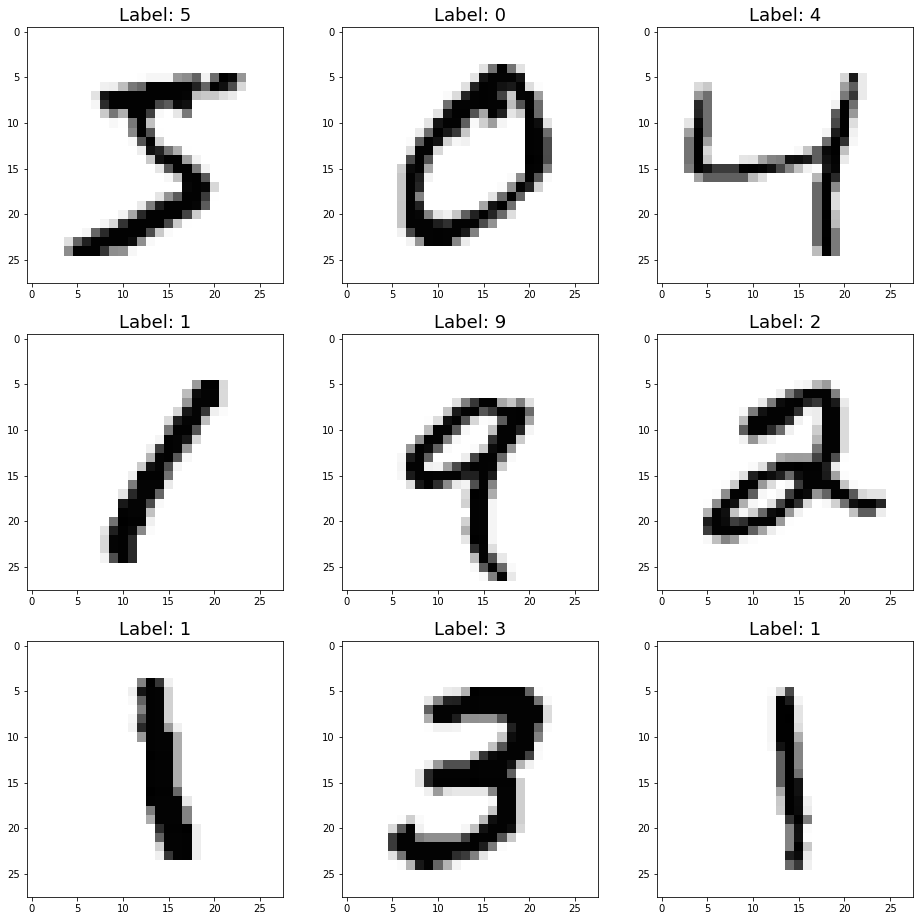

In [4]:
from tensorflow import keras

train_imgs = read_images("mnist/train-images.gz").astype("float32") / 255
train_labels = read_labels("mnist/train-labels.gz")
train_clabels = keras.utils.to_categorical(train_labels, 10)

test_imgs = read_images("mnist/test-images.gz").astype("float32") / 255
test_labels = read_labels("mnist/test-labels.gz")
test_clabels = keras.utils.to_categorical(test_labels, 10)

plot_images(train_imgs, train_labels, 3 * 3)

In [28]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import itertools as it

def generate_networks(layers_cnt):
    print("{} layers network generating...".format(layers_cnt))
    def add_layer(is_square, layer_cnt, layer_ind, layers, last_shape):
        if layer_cnt == layer_ind:
            return [layers]
        res = []
        (h, w, l_out) = last_shape
        for kernel_def in range(2, 6):
            if is_square:
                kernel_height, kernel_width = (kernel_def, kernel_def)
            else:
                kernel_height, kernel_width = (kernel_def, kernel_def // 2)
            for stride_w in range(1, kernel_width + 1, 2):
                if (w - kernel_width) % stride_w != 0:
                    continue
                next_w = (w - kernel_width) // stride_w + 1
                if next_w < 1:
                    continue
                for stride_h in range(1, kernel_height + 1, 2):
                    if (h - kernel_height) % stride_h != 0:
                        continue
                    next_h = (h - kernel_height) // stride_h + 1
                    if next_h < 1:
                        continue
                    for out in [16, 32, 64]:
                        if out < l_out:
                            continue
                        kernel = (kernel_height, kernel_width)
                        stride = (stride_h, stride_w)
                        conv = Conv2D(out, kernel, stride, activation="relu")
                        for pool_w in range(2, 5):
                            if next_w % pool_w != 0:
                                continue
                            for pool_h in range(2, 5):
                                if next_h % pool_h != 0:
                                    continue
                                pool = MaxPooling2D(pool_size=(pool_h, pool_w))
                                new_shape = (next_h // pool_h, next_w // pool_w, out)
                                for net in add_layer(is_square, layer_cnt, layer_ind + 1, layers + [conv, pool], new_shape):
                                    res.append(net)
        return res

    models = []
    input_shape = (28, 28, 1)
    for is_square in [True, False]:
        for model in add_layer(is_square, layers_cnt, 0, [], input_shape):
            models.append(model)
    return models


In [30]:
models_1 = generate_networks(1)
models_2 = generate_networks(2)
models_3 = generate_networks(3)
print("\n1 layer: {}\n2 layers: {}\n3 layers: {}".format(len(models_1), len(models_2), len(models_3)))

1 layers network generating...
2 layers network generating...
3 layers network generating...

1 layer: 60
2 layers: 1056
3 layers: 750


In [31]:
def find_best(threads, models):
    train_imgs = read_images("train-images.gz").astype("float32") / 255
    train_clabels = keras.utils.to_categorical(read_labels("train-labels.gz"), 10)
    test_imgs = read_images("test-images.gz").astype("float32") / 255
    test_clabels = keras.utils.to_categorical(read_labels("test-labels.gz"), 10)
    best = None
    best_score = (1e9, -1)
    cnt = 0
    all_cnt = len(models)
    for model in models:
        cnt += 1
        print("\r{}/{}".format(cnt * threads, all_cnt * threads), end='')
        try:
            model = keras.Sequential([Input(shape=(28, 28, 1))] + model + [Flatten(), Dense(10, activation="softmax")])
            model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            model.fit(train_imgs, train_clabels, batch_size=256, epochs=5, validation_split=0.1, steps_per_epoch=100, verbose=0)
            score = model.evaluate(test_imgs, test_clabels, verbose=0)
            if score[0] < best_score[0]:
                best_score = score
                best = model
        except BaseException:
            pass
    return (best, best_score)


In [32]:
import random
from time import process_time
from multiprocessing.dummy import Pool as ThreadPool


def split_models(models, cnt):
    len_m = len(models)
    result = []
    for cur in range(cnt):
        cur_l = []
        ind = cur
        while ind < len_m:
            cur_l.append(models[ind])
            ind += cnt
        result.append(cur_l)    
    return result

all_models = models_1 + models_2 + models_3

threads = 2
pool = ThreadPool(threads)
result = pool.map(lambda x: find_best(threads, x), split_models(all_models, threads))
pool.close()
pool.join()

1866/1866

In [33]:
best_of_the_best = None
best_of_the_best_score = (1e9, -1)
for best, best_score in result:
    if best_score[0] < best_of_the_best_score[0]:
        best_of_the_best_score = best_score
        best_of_the_best = best

print("Test loss", best_of_the_best_score[0])
print("Test accuracy:", best_of_the_best_score[1])
best_of_the_best.summary()

Test loss 0.030443517491221428
Test accuracy: 0.9907000064849854
Model: "sequential_404"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7537 (Conv2D)         (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_6683 (MaxPooli (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7567 (Conv2D)         (None, 4, 4, 64)          102464    
_________________________________________________________________
max_pooling2d_6688 (MaxPooli (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_404 (Flatten)        (None, 256)               0         
_________________________________________________________________
dense_404 (Dense)            (None, 10)                2570      
Total params: 106,698
Trainable params: 106,698
Non-t

In [34]:
for i in range(0, len(best_of_the_best.layers) - 2, 2):
    print("Layer {}:".format(i // 2 + 1))
    conv2d = best_of_the_best.layers[i]
    max_pool = best_of_the_best.layers[i + 1]
    print("  Conv2D: \n    Kernel shape: {}\n    Strides: {}".format(conv2d.kernel.shape, conv2d.strides))
    print("  MaxPool: \n    Shape: {}\n    Strides: {}".format(max_pool.pool_size, conv2d.strides))

Layer 1:
  Conv2D: 
    Kernel shape: (5, 5, 1, 64)
    Strides: (1, 1)
  MaxPool: 
    Shape: (3, 3)
    Strides: (1, 1)
Layer 2:
  Conv2D: 
    Kernel shape: (5, 5, 64, 64)
    Strides: (1, 1)
  MaxPool: 
    Shape: (2, 2)
    Strides: (1, 1)


In [9]:
from tensorflow import keras, device
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

network = keras.Sequential(
    [
        Input(shape=(28, 28, 1)),
        Conv2D(64, kernel_size=(5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, kernel_size=(5, 5), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation="softmax"),
    ]
)

with device("/cpu:0"):
    network.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    network.fit(train_imgs, train_clabels, batch_size=128, epochs=30, validation_split=0.1)

Epoch 1/30
422/422 [==============================] - 13s 31ms/step - loss: 0.2580 - accuracy: 0.9291 - val_loss: 0.0695 - val_accuracy: 0.9802
Epoch 2/30
422/422 [==============================] - 20s 48ms/step - loss: 0.0674 - accuracy: 0.9797 - val_loss: 0.0497 - val_accuracy: 0.9878
Epoch 3/30
422/422 [==============================] - 31s 72ms/step - loss: 0.0466 - accuracy: 0.9859 - val_loss: 0.0433 - val_accuracy: 0.9890
Epoch 4/30
422/422 [==============================] - 30s 71ms/step - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.0409 - val_accuracy: 0.9892
Epoch 5/30
422/422 [==============================] - 32s 75ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0386 - val_accuracy: 0.9905
Epoch 6/30
422/422 [==============================] - 32s 77ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0416 - val_accuracy: 0.9887
Epoch 7/30
422/422 [==============================] - 33s 77ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.0419 - val_accuracy:

In [10]:
with device("/cpu:0"):
    score = network.evaluate(train_imgs, train_clabels, verbose=0)
    score_test = network.evaluate(test_imgs, test_clabels, verbose=0)

print("Train loss:", score[0])
print("Train accuracy:", score[1])
print()
print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Train loss: 0.005944317672401667
Train accuracy: 0.9990500211715698

Test loss: 0.03556312620639801
Test accuracy: 0.992900013923645


In [11]:
def build_matrices(network, imgs, labels):
    with device("/cpu:0"):
        predictions = network.predict(imgs)
    
    base_matrix = [[0] * 10 for _ in range(10)]
    like_matrix = [[None] * 10 for _ in range(10)]
    prob_like_matrix = [[0] * 10 for _ in range(10)]
    is_mistake = [[False] * 10 for _ in range(10)]
    for i in range(len(imgs)):
        pred = list(predictions[i])
        strict_pred = pred.index(max(pred))
        actual = labels[i]
        base_matrix[actual][strict_pred] += 1
        
        for j in range(10):
            if pred[j] > prob_like_matrix[actual][j]:
                prob_like_matrix[actual][j] = pred[j]
                like_matrix[actual][j] = imgs[i]
                is_mistake[actual][j] = strict_pred == j and actual != strict_pred
    return (base_matrix, like_matrix, prob_like_matrix, is_mistake)

def plot_like_matrix(like_matrix, prob_like_matrix, is_mistake, labels):
    fig = plt.figure(figsize=(35, 35))
    rows_cnt = len(like_matrix)
    imgs_by_row = len(like_matrix[0])
    for i in range(rows_cnt):
        for j in range(imgs_by_row):
            prob = prob_like_matrix[i][j]
            if prob < 1e-2:
                continue
            color = "red" if is_mistake[i][j] else "green"
            ax = fig.add_subplot(rows_cnt, imgs_by_row, i * imgs_by_row + j + 1)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            ax.imshow(like_matrix[i][j], cmap='Greys')
            ax.set_xlabel("Prob: {:.3f}".format(prob_like_matrix[i][j]), fontsize=14, color=color)
            ax.set_title("{} like {}".format(labels[i], labels[j]), fontsize=18)
    
    fig.tight_layout()

[[ 977    0    0    0    0    0    2    1    0    0]
 [   2 1132    0    0    0    0    1    0    0    0]
 [   1    0 1028    0    0    0    0    2    1    0]
 [   0    0    1 1002    0    5    0    0    2    0]
 [   0    0    0    0  978    0    2    0    0    2]
 [   2    0    0    2    0  884    2    0    0    2]
 [   3    3    0    0    1    1  949    0    1    0]
 [   0    3    4    0    0    1    0 1015    1    4]
 [   1    1    2    0    0    1    0    0  967    2]
 [   1    0    0    1    4    2    1    1    2  997]]


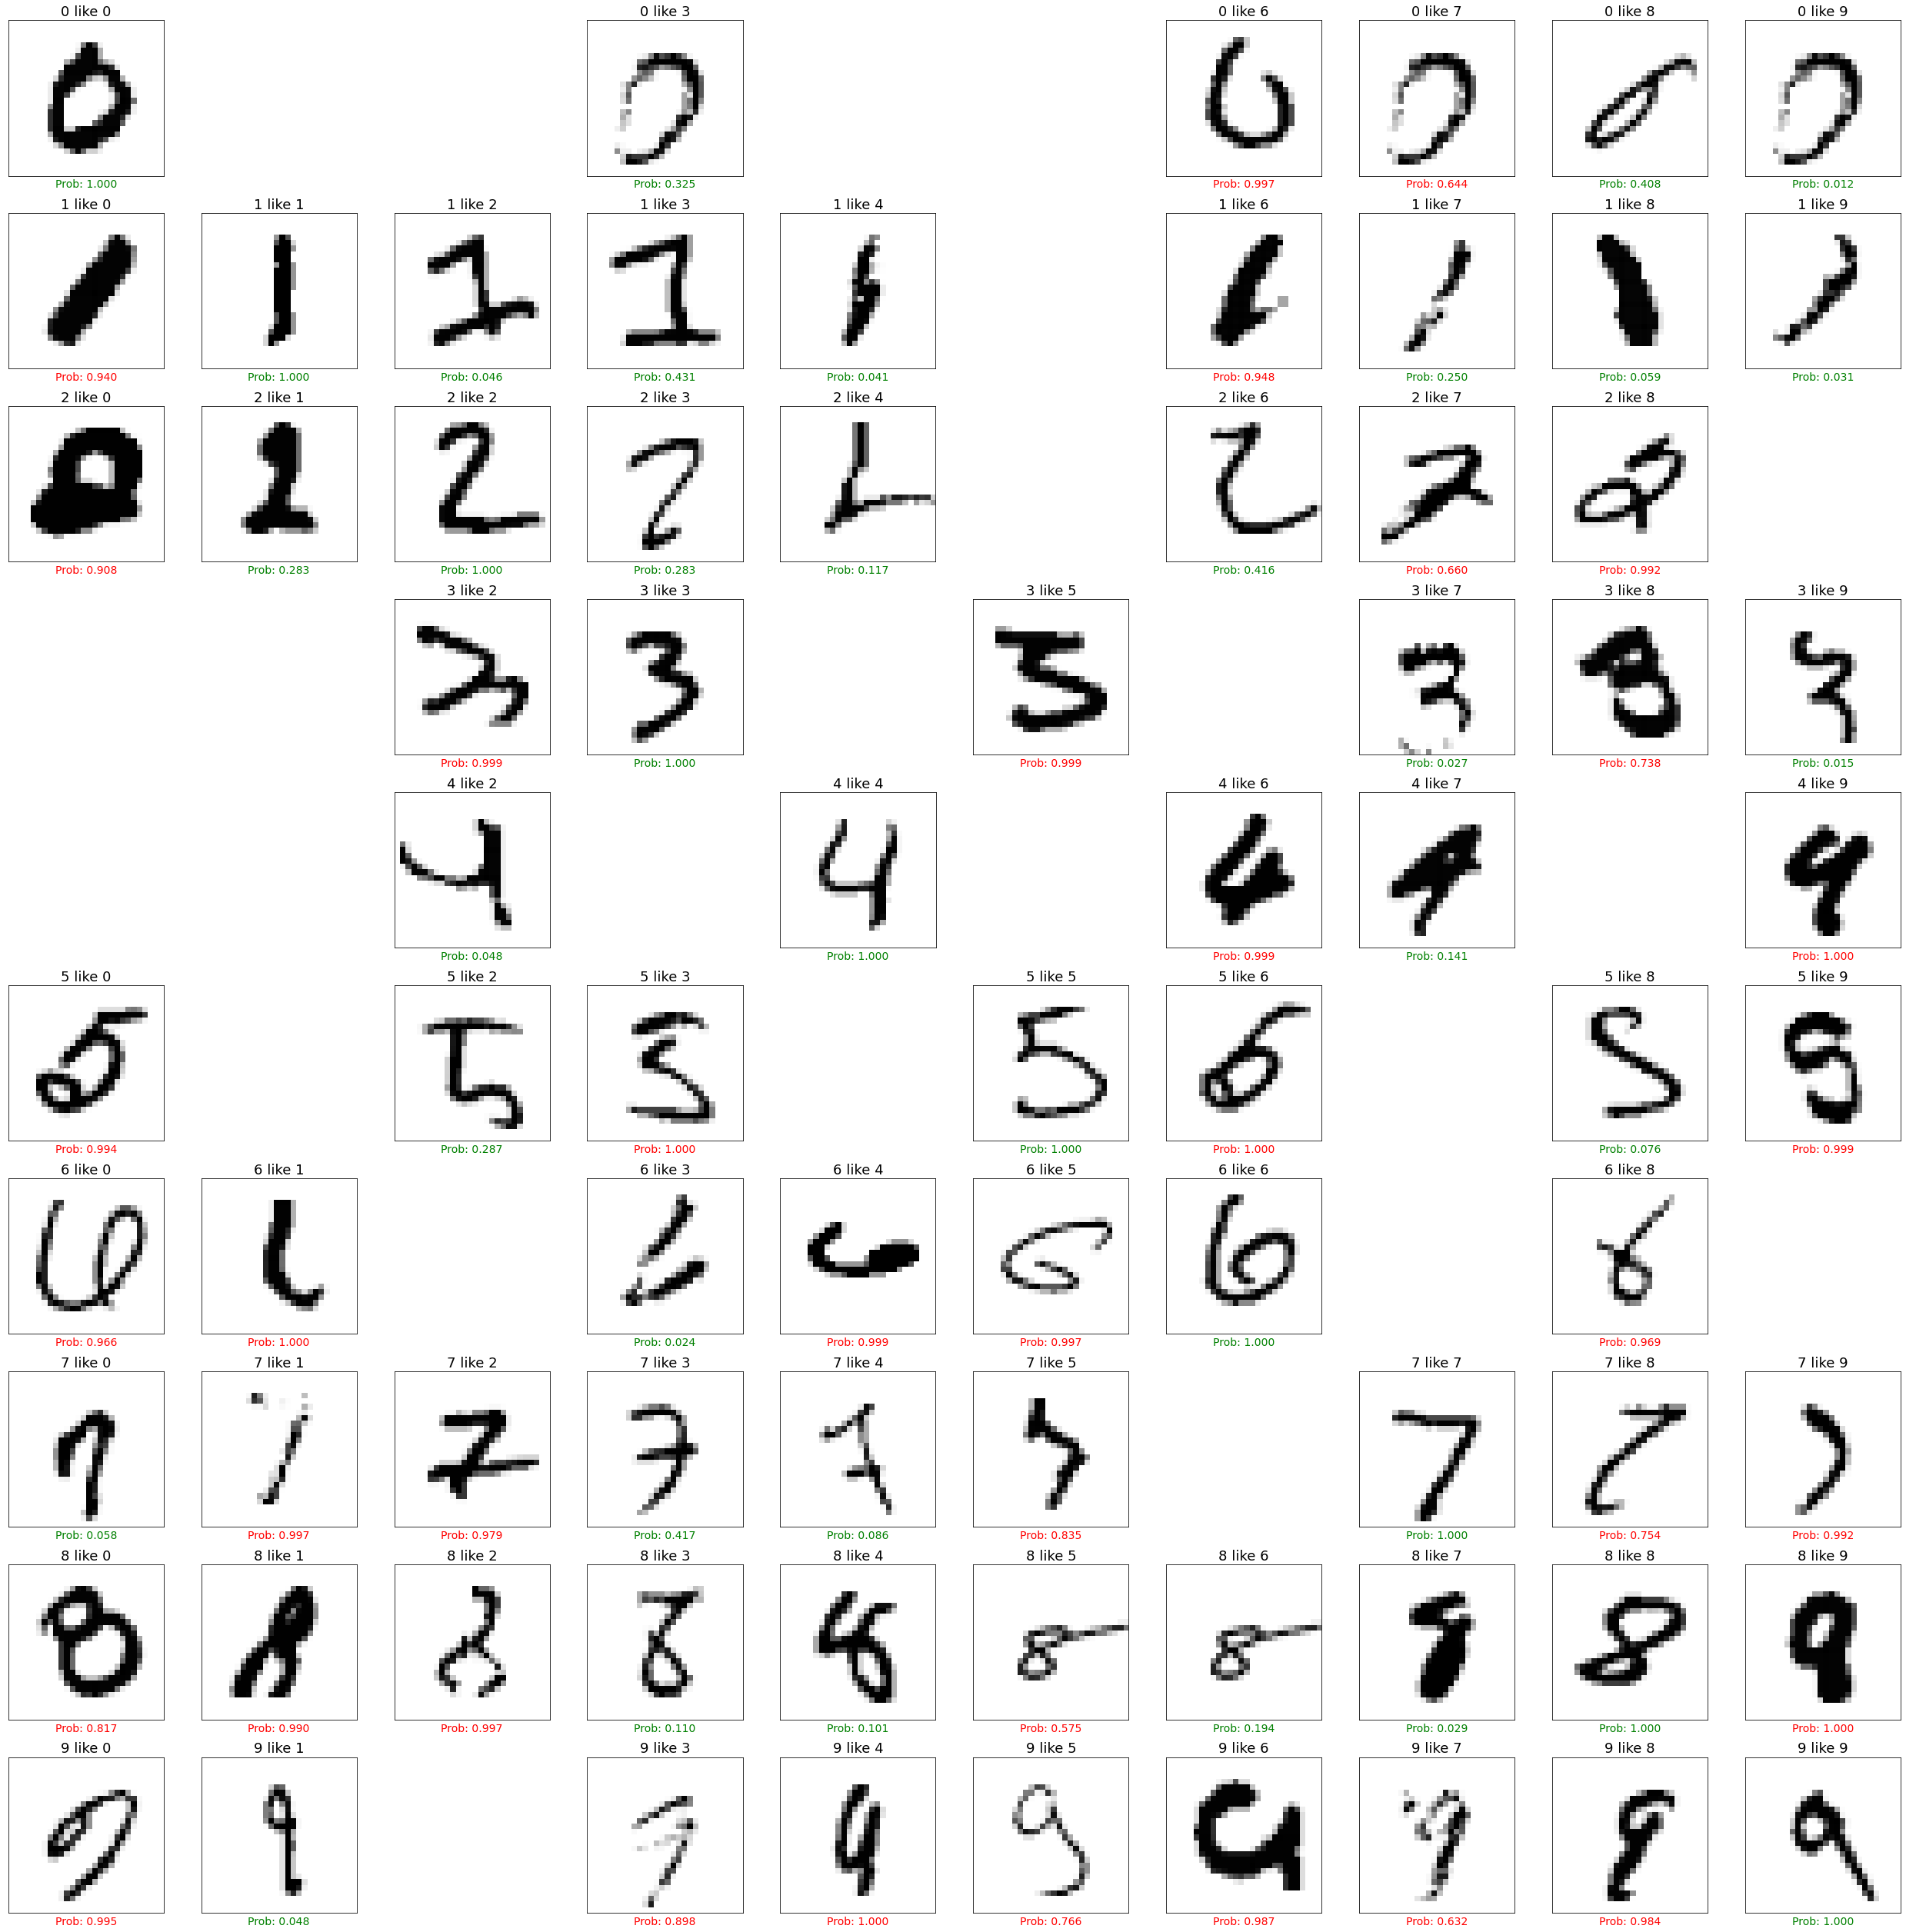

In [12]:
import numpy as np

base_matrix, like_matrix, prob_like_matrix, is_mistake = build_matrices(network, test_imgs, test_labels)
print(np.array(base_matrix))
plot_like_matrix(like_matrix, prob_like_matrix, is_mistake, list(range(10)))

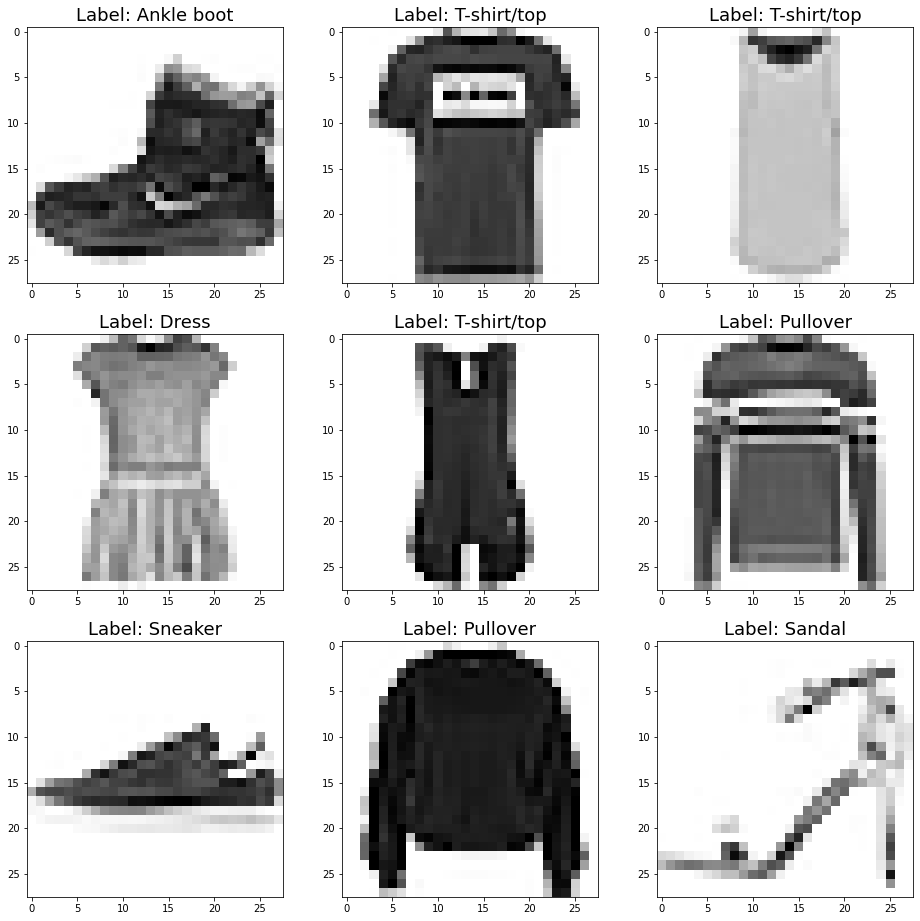

In [13]:
train_fashion_imgs = read_images("fashion/train-images.gz").astype("float32") / 255
train_fashion_labels = read_labels("fashion/train-labels.gz")
train_fashion_clabels = keras.utils.to_categorical(train_fashion_labels, 10)

test_fashion_imgs = read_images("fashion/test-images.gz").astype("float32") / 255
test_fashion_labels = read_labels("fashion/test-labels.gz")
test_fashion_clabels = keras.utils.to_categorical(test_fashion_labels, 10)

fashion_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

plot_images(train_fashion_imgs, list(map(lambda x: fashion_labels[x], train_fashion_labels)), 3 * 3)

In [14]:
fashion_network = keras.Sequential(
    [
        Input(shape=(28, 28, 1)),
        Conv2D(64, kernel_size=(5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, kernel_size=(5, 5), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation="softmax"),
    ]
)

with device("/cpu:0"):
    fashion_network.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    fashion_network.fit(train_fashion_imgs, train_fashion_clabels, batch_size=128, epochs=30, validation_split=0.1)

Epoch 1/30
422/422 [==============================] - 15s 36ms/step - loss: 0.5924 - accuracy: 0.7936 - val_loss: 0.4052 - val_accuracy: 0.8617
Epoch 2/30
422/422 [==============================] - 33s 77ms/step - loss: 0.3689 - accuracy: 0.8706 - val_loss: 0.3507 - val_accuracy: 0.8720
Epoch 3/30
422/422 [==============================] - 31s 74ms/step - loss: 0.3204 - accuracy: 0.8878 - val_loss: 0.3345 - val_accuracy: 0.8823
Epoch 4/30
422/422 [==============================] - 31s 74ms/step - loss: 0.2916 - accuracy: 0.8967 - val_loss: 0.3048 - val_accuracy: 0.8902
Epoch 5/30
422/422 [==============================] - 34s 81ms/step - loss: 0.2686 - accuracy: 0.9051 - val_loss: 0.2847 - val_accuracy: 0.8953
Epoch 6/30
422/422 [==============================] - 34s 81ms/step - loss: 0.2530 - accuracy: 0.9103 - val_loss: 0.2840 - val_accuracy: 0.8983
Epoch 7/30
422/422 [==============================] - 35s 82ms/step - loss: 0.2381 - accuracy: 0.9166 - val_loss: 0.2701 - val_accuracy:

In [15]:
with device("/cpu:0"):
    score = fashion_network.evaluate(train_fashion_imgs, train_fashion_clabels, verbose=0)
    score_test = fashion_network.evaluate(test_fashion_imgs, test_fashion_clabels, verbose=0)

print("Fashion train loss:", score[0])
print("Fashion train accuracy:", score[1])
print()
print("Fashion test loss:", score_test[0])
print("Fashion test accuracy:", score_test[1])

Fashion train loss: 0.09311162680387497
Fashion train accuracy: 0.9694499969482422

Fashion test loss: 0.3487199544906616
Fashion test accuracy: 0.9039999842643738


[[905   0  16   7   3   1  57   0  10   1]
 [  4 984   1   8   0   0   1   0   2   0]
 [ 22   1 905   5  36   0  29   0   2   0]
 [ 56   8  17 846  44   0  28   0   1   0]
 [  3   1  93  16 834   0  53   0   0   0]
 [  0   0   0   0   0 981   0  14   0   5]
 [177   1  81  12  56   0 669   0   4   0]
 [  0   0   0   0   0   9   0 971   0  20]
 [  5   0   6   3   1   1   3   3 978   0]
 [  0   0   1   0   0   7   0  25   0 967]]


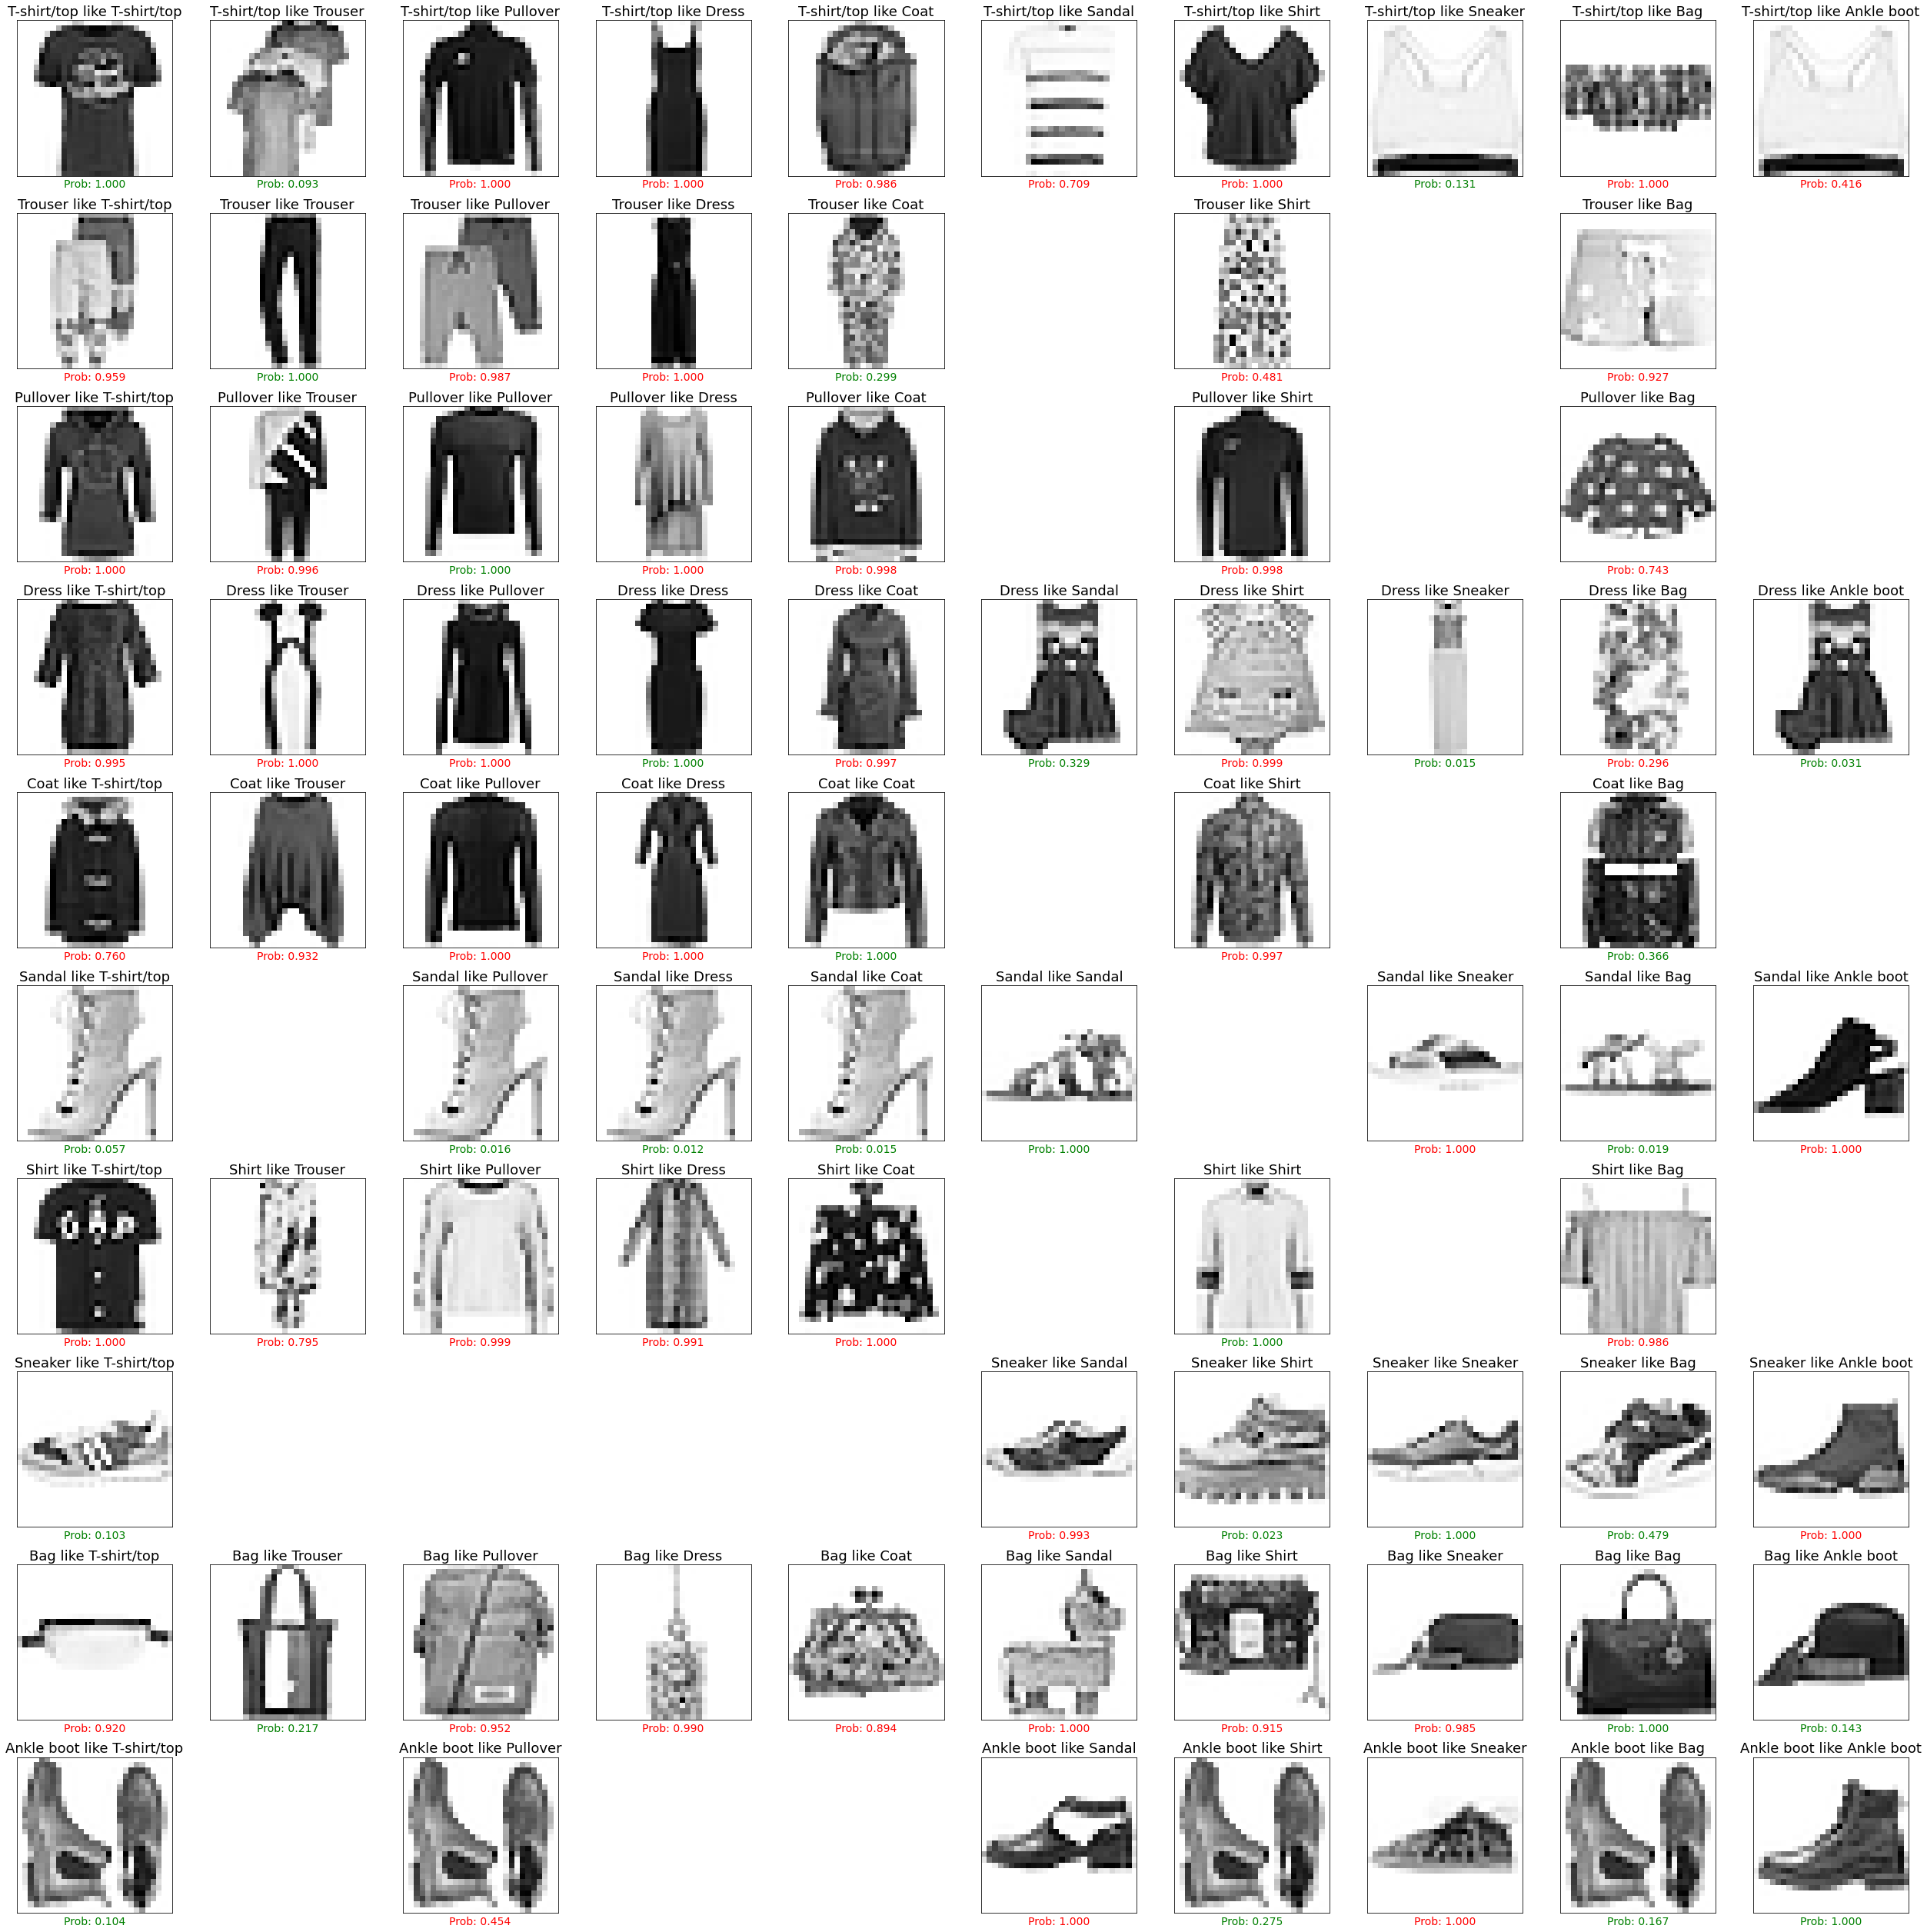

In [16]:
base_matrix, like_matrix, prob_like_matrix, is_mistake = build_matrices(fashion_network, test_fashion_imgs, test_fashion_labels)
print(np.array(base_matrix))
plot_like_matrix(like_matrix, prob_like_matrix, is_mistake, fashion_labels)